In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
unconfined=True

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import pandas as pd
import sys
import os
import copy
import tqdm
import itertools
import numpy as np
from itertools import product
from _utils import assign_hydrogen_pdbinfo, map_mol_with_noe

# Distance Calc s

In [3]:
mol = Chem.MolFromPDBFile("/home/kkajo/Workspace/Conformers/CsA/CsA_chcl3_noebounds_numconf5400.pdb", removeHs = False)
bl_mol = Chem.MolFromPDBFile("/home/kkajo/Workspace/Conformers/CsA/CsA_baseline_numconf5400.pdb", removeHs = False)
omegamc_mol = Chem.MolFromPDBFile("/home/kkajo/Workspace/Conformers/CsA/Reordered_CsA_OMEGA_MC_numconf219.pdb", removeHs = False)

df = pd.read_csv("../CsA/CsA_chcl3_noebounds.csv", sep = "\s", comment = "#")

mol_atom_names2atom_index, noe_atom_names2mol_atom_names, noe_atom_pair2upper_distance = map_mol_with_noe(mol, df, verbose = False)

index_1, index_2 = [], [] #symmetric, thus two lists are interchangable
labels = []
ref_val = []
res_dist = [] # distance between residuals
bond_dist = [] # number of bonds between atoms

bond_order = Chem.rdmolops.GetDistanceMatrix(mol)

prev_a = 0 
prev_b = 0

for key, val in noe_atom_pair2upper_distance.items():
    tmp_1 = noe_atom_names2mol_atom_names[key[0]]
    tmp_2 = noe_atom_names2mol_atom_names[key[1]]
    #print(key[0])
    #print(tmp_1)
    a = mol_atom_names2atom_index[tmp_1]
    #print(tmp_2[0])
    b = mol_atom_names2atom_index[tmp_2]
    
    if not(b==prev_a and a==prev_b): # ignore reversed pair
        for item in product(a,b):
            #print(item)
            index_1.append(item[0]) # RDKit indexing starts at 0!
            index_2.append(item[1])
            ref_val.append(val)
            
            r1 = int(tmp_1[0]) # string to int conversion
            r2 = int(tmp_2[0])
            if abs(r1 - r2) <= 5: # take the shorter route along the ring, 11 residuals total
                dist = abs(r1 - r2)
            else:
                dist = abs(abs(r1 - r2) - 11)
            res_dist.append(dist)
            
            bd = int(bond_order[item[0], item[1]])
            bond_dist.append(bd)
            
            labels.append("{}-{} {}R {}B {}:{}{}-{}:{}{} ({:0.2f})".format(tmp_1[0], tmp_2[0], dist, bd, item[0], tmp_1[0], 
                                                                tmp_1[1], item[1], tmp_2[0], tmp_2[1], val))
    
    prev_a = a
    prev_b = b

# sort everything for bond_dist (first arg in zip) 
res_dist, bond_dist, labels, ref_val, index_1, index_2 = (list(t) for t in zip(*sorted(zip(bond_dist, res_dist, labels, ref_val, index_1, index_2))))

distance_matrix_for_each_conformer = np.array([Chem.Get3DDistanceMatrix(mol, i) for i in tqdm.tqdm(range(mol.GetNumConformers()))])

with_noe = distance_matrix_for_each_conformer[:, index_1, index_2]

# baseline
distance_matrix_for_each_conformer = np.array([Chem.Get3DDistanceMatrix(bl_mol, i) for i in tqdm.tqdm(range(bl_mol.GetNumConformers()))])
baseline = distance_matrix_for_each_conformer[:, index_1, index_2]

# omegamc
distance_matrix_for_each_conformer = np.array([Chem.Get3DDistanceMatrix(omegamc_mol, i) for i in tqdm.tqdm(range(omegamc_mol.GetNumConformers()))])
omegamc = distance_matrix_for_each_conformer[:, index_1, index_2]

/home/kkajo/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """
100%|██████████| 219/219 [00:00<00:00, 2237.53it/s]


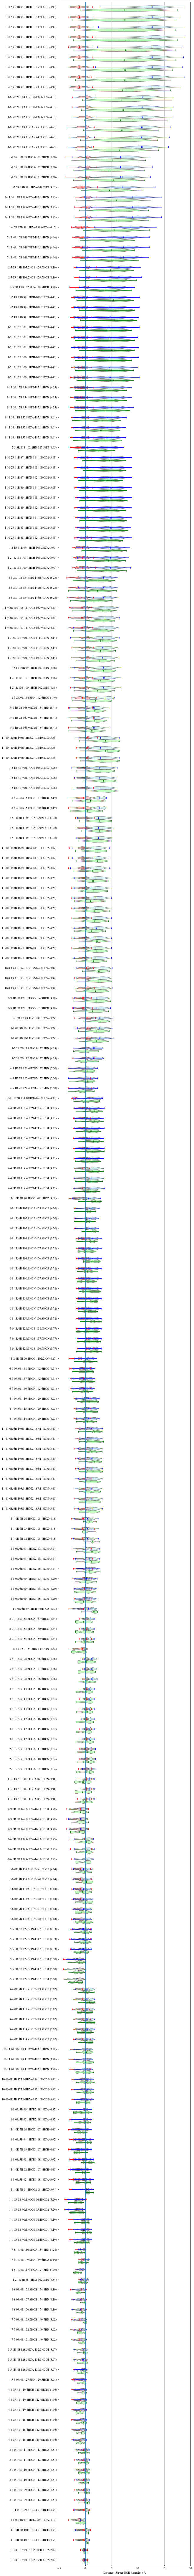

CPU times: user 8.78 s, sys: 144 ms, total: 8.92 s
Wall time: 8.77 s


In [9]:
plot_1 = copy.copy(with_noe) - ref_val
plot_2 = copy.copy(baseline) - ref_val
plot_3 = copy.copy(omegamc) - ref_val

widths = 0.3
offset = 0.3
fig1, ax1 = plt.subplots(1, 1, figsize = (8,160))
    
def set_violin_color(vp, markercolor, bodycolor):
    for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
        vps = vp[partname]
        vps.set_edgecolor(markercolor)
        vps.set_linewidth(1)
    for pc in vp['bodies']:
        pc.set_facecolor(bodycolor)
        pc.set_edgecolor('black')
        pc.set_alpha(0.5)
    
# ax1.set_title('Basic Plot')
red_square = dict(markerfacecolor='r', marker='o')
blue_square = dict(markerfacecolor='b', marker='o')
green_square = dict(markerfacecolor='g', marker='o')

#bp_1 = ax1.boxplot([plot_1[:,i] for i in range(plot_1.shape[1])], vert = False, widths = widths, 
#                   flierprops = red_square, positions = np.array(range(plot_1.shape[1])), manage_ticks=False)
vp_1 = ax1.violinplot([plot_1[:,i] for i in range(plot_1.shape[1])], vert = False, widths = widths, 
                      positions = np.array(range(plot_1.shape[1])), showmeans=True, showmedians=True, 
                      showextrema=True)
vp_2 = ax1.violinplot([plot_2[:,i] for i in range(plot_2.shape[1])], vert = False, widths = widths, 
                      positions = np.array(range(plot_2.shape[1])), showmeans=True, showmedians=True, 
                      showextrema=True)
vp_3 = ax1.violinplot([plot_3[:,i] for i in range(plot_3.shape[1])], vert = False, widths = widths, 
                      positions = np.array(range(plot_3.shape[1])) - offset, showmeans=True, showmedians=True, 
                      showextrema=True)

    
set_violin_color(vp_1, "red", "lightcoral")
set_violin_color(vp_2, "blue", "lightblue")
set_violin_color(vp_3, "green", "lightgreen")

ax1.set_xlabel('Distance - Upper NOE Restraint / Å')
plt.grid(axis = "x", which = "both")
plt.yticks(range(plot_1.shape[1]), labels)
plt.ylim(0 - 0.5, plot_1.shape[1] - 0.5)
plt.xlim(-5, 20)
plt.axvline(x=0)

%time plt.show()

# Check if any conformers satisfy all restraints

In [10]:
def restraints_check(conf):
    tmp = copy.copy(conf) - ref_val
    tmp[tmp < 0] = 0
    best_ind = (np.argsort(np.sum(tmp, 1))[:10])

    print("Indices of best: \t\t\t\t{}".format(best_ind))
    least_violation = []
    for i in best_ind:
        least_violation.append(np.sum(tmp,1)[i])
    print("Summed violations of best / nm: \t\t\t{}".format(np.around(np.array(least_violation),2)))
    violation_per_bond = [least_violation/len(labels) for least_violation in least_violation]
    print("Summed violations / #bonds considered / nm: \t{}".format(np.around(np.array(violation_per_bond),2)))
    if least_violation[0]>0:
        print('No conformer fulfills all NOE restraints')
    return None

print("With NOE restraints:")
restraints_check(with_noe)

print("\nBaseline")
restraints_check(baseline)

print("\nOmega MC")
restraints_check(omegamc)

With NOE restraints:
Indices of best: 				[3489 1089 3207 1741 2945 1987  522 1734 4070 2327]
Summed violations of best / nm: 			[23.16 23.82 23.97 23.99 23.99 24.18 24.27 24.32 24.33 24.36]
Summed violations / #bonds considered / nm: 	[0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.1  0.1 ]
No conformer fulfills all NOE restraints

Baseline
Indices of best: 				[2715 2354 3504 4402  546 3107 3760 3539 1799 4432]
Summed violations of best / nm: 			[394.62 414.21 416.13 420.8  421.68 427.6  428.58 434.16 435.23 436.13]
Summed violations / #bonds considered / nm: 	[1.54 1.62 1.63 1.64 1.65 1.67 1.67 1.7  1.7  1.7 ]
No conformer fulfills all NOE restraints

Omega MC
Indices of best: 				[ 38  14 156   4  45  70 103  82 167 110]
Summed violations of best / nm: 			[279.09 315.55 332.18 335.07 335.1  336.5  339.31 347.02 358.1  359.84]
Summed violations / #bonds considered / nm: 	[1.09 1.23 1.3  1.31 1.31 1.31 1.33 1.36 1.4  1.41]
No conformer fulfills all NOE restraints


# Calculate RMSD of Conformers

In [6]:
import mdtraj as md
import cpeptools
import tempfile
def get_rmsd(smiles, pdb_path, ref_pdb_path): #not full rmsd, just ring + beta atom rmsd
    smiles_mol = Chem.MolFromSmiles(smiles)
    ref_mol = Chem.MolFromPDBFile(ref_pdb_path)
    mol = Chem.MolFromPDBFile(pdb_path)

    ref_mol = AllChem.AssignBondOrdersFromTemplate(smiles_mol,ref_mol)
    mol = AllChem.AssignBondOrdersFromTemplate(smiles_mol, mol)
    order = list(mol.GetSubstructMatches(ref_mol)[0])
    mol = Chem.RenumberAtoms(mol, order)

    indices = cpeptools.get_largest_ring(ref_mol)
    indices = cpeptools.mol_ops.get_neighbour_indices(ref_mol, indices)
    #assert len(set(indices) - set(cpeptools.get_largest_ring(mol))) == 0, "ring atom indices do not agree"

    tmp_dir = tempfile.mkdtemp()
    ref_pdb_filename = tempfile.mktemp(suffix=".pdb", dir = tmp_dir)
    pdb_filename = tempfile.mktemp(suffix=".pdb", dir = tmp_dir)
    # chem add Hs
    Chem.MolToPDBFile(ref_mol, ref_pdb_filename)
    Chem.MolToPDBFile(mol, pdb_filename)

    ref  = md.load(ref_pdb_filename)
    #ref = ref.center_coordinates()
    compare = md.load(pdb_filename)
    #compare = compare.center_coordinates()
    #print(compare, mol.GetNumConformers())
    print(" {} has {} conformers".format(smiles, len(compare)))


    bb_rmsd = md.rmsd(compare, ref, 0, atom_indices = indices)
    compare = compare.superpose(ref, 0, atom_indices = indices)
    ten_best = compare[np.argsort(bb_rmsd)[:10]]
    return bb_rmsd, compare[np.argmin(bb_rmsd)], ten_best

In [7]:
smiles = "CC[C@H]1C(=O)N(CC(=O)N([C@H](C(=O)N[C@H](C(=O)N([C@H](C(=O)N[C@H](C(=O)N[C@@H](C(=O)N([C@H](C(=O)N([C@H](C(=O)N([C@H](C(=O)N([C@H](C(=O)N1)[C@@H]([C@H](C)C/C=C/C)O)C)C(C)C)C)CC(C)C)C)CC(C)C)C)C)C)CC(C)C)C)C(C)C)CC(C)C)C)C"
NOE_pdb = "/home/kkajo/Workspace/Conformers/CsA/CsA_chcl3_noebounds_numconf5400.pdb"
bl_pdb = "/home/kkajo/Workspace/Conformers/CsA/CsA_baseline_numconf5400.pdb"
omega_mc_pdb = "/home/kkajo/Workspace/Conformers/CsA/Reordered_CsA_OMEGA_MC_numconf219.pdb"
ref_pdb = "../CsA/ref.pdb"
md.load(conf_pdb)[0].save("./tmp.pdb")
%time bb_rmsd, tmp, best_NOE = get_rmsd(smiles, NOE_pdb, ref_pdb)
bl_rmsd, _, best_bl = get_rmsd(smiles, bl_pdb, ref_pdb)
omegamc_rmsd, _, best_omegamc = get_rmsd(smiles, omega_mc_pdb, ref_pdb)

NameError: name 'conf_pdb' is not defined

In [ ]:
np.sort(bb_rmsd)[:10]

In [ ]:
np.sort(bl_rmsd)[:10]

In [ ]:
np.sort(omegamc_rmsd)[:10]

In [ ]:
best_NOE.save("./NOE_best_rmsd.pdb")
best_bl.save("./bl_best_rmsd.pdb")
best_omegamc.save("./omegamc_best_rmsd.pdb")

# Visualization

In [ ]:
tmp.save("./rmsd_tmp.pdb")
ten_tmp.save("./rmsd_ten_tmp.pdb")

Compare best to reference

In [ ]:
import nglview as nv

view = nv.show_file("./rmsd_tmp.pdb")
view.add_representation('cartoon', selection='protein', color='black')
view.add_component("../CsA/ref.pdb", color='blue')

view

Show variation of the ten best structures

In [ ]:


#view2 = nv.show_file("./rmsd_tmp.pdb")

view2 = nv.show_structure_file("./rmsd_ten_tmp.pdb", default_representation=False)
view2.add_component("../CsA/ref.pdb", selection='protein', color='black')
view2.add_representation('licorice', selection='protein', color='atomindex')
view2.center()
view2

Atomic structure of best fit

In [ ]:
view3 = nv.show_file("./rmsd_tmp.pdb")
view3.add_cartoon("protein", color_scheme="residueindex")
view3.add_ball_and_stick("protein")
view3

# Graphics testing

Get some random data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)

# fake up some data
spread = np.random.rand(50) * 100
center = np.ones(25) * 50
flier_high = np.random.rand(10) * 100 + 100
flier_low = np.random.rand(10) * -100
data = np.concatenate((spread, center, flier_high, flier_low))

Plot it

In [ ]:
fig1, ax1 = plt.subplots(1, 1, figsize = (12,9))
ax1.set_title('Basic Plot')
red_square = dict(markerfacecolor='r', marker='o')
blue_square = dict(markerfacecolor='b', marker='o')
median = dict(color='k')
ax1.boxplot([data, -data], notch = True, positions = np.array(range(2))*2.0-0.2, vert = False, flierprops = red_square, medianprops = median)
ax1.boxplot([data, -data], positions = np.array(range(2))*2.0+0.2, vert = False, flierprops = blue_square, whis=1.5)
ax1.set_yticks([0,1,2], minor=True)
plt.grid(axis = "y", which = "both")
#plt.grid(axis = "x", which = "major")
plt.axvline(x=2.20589566)

plt.show()